# Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

# Parameters

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128

EPOCHS = 5
STEPS_PER_EPOCH= 100

LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

# Data preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_dir = '/content/drive/MyDrive/g_dataset/img_align_celeba/img_align_celeba/'
            
data = utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

# Repeat the dataset
data = data.repeat()

Found 45743 files belonging to 1 classes.


In [ ]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train_data = data.map(lambda x: preprocess(x))

In [ ]:
"""num_samples = (tf.data.experimental.cardinality(data).numpy() * BATCH_SIZE) 

# Split the data into training, validation, and test sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = int(0.15 * num_samples)

train_data = data.take(train_size // BATCH_SIZE)
val_data = data.skip(train_size // BATCH_SIZE).take(val_size // BATCH_SIZE)
test_data = data.skip((train_size + val_size) // BATCH_SIZE).take(test_size // BATCH_SIZE)"""

In [ ]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
import os

# Set the path of the new directory
new_dir = '/content/output'

# Create the directory
os.makedirs(new_dir, exist_ok=True)

# Build the WGAN-GP

In [ ]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544

In [ ]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        524288    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        5242

In [ ]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [ ]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [ ]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

# Compile the GAN

In [ ]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize


def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
     # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
    # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim, real_images, fid_model):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.real_images = real_images
        self.fid_model = fid_model


    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generatedimg%03d.png" % (epoch), cmap=None)

        # FID

        # convert integer to floating point values
        images1 = generated_images.astype('float32')
        #images2 = self.real_images.astype('float32')
        images2 = self.real_images.numpy().astype('float32')

        # resize images
        images1 = scale_images(images1, (299,299,3))
        images2 = scale_images(images2, (299,299,3))

        # pre-process images
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)



        fid = calculate_fid(self.fid_model, images1, images2)
        print(f'FID score at epoch {epoch}: {fid}')

In [ ]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

# Train the GAN

In [ ]:
num_images = 10
real_images = next(iter(train_data.take(num_images)))

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -19.4382 - c_wass_loss: -25.3706 - c_gp: 0.5932 - g_loss: 3.0699 - c_acc: 95.7812 - g_acc: 65.2344
Saved to ./output/generatedimg000.png


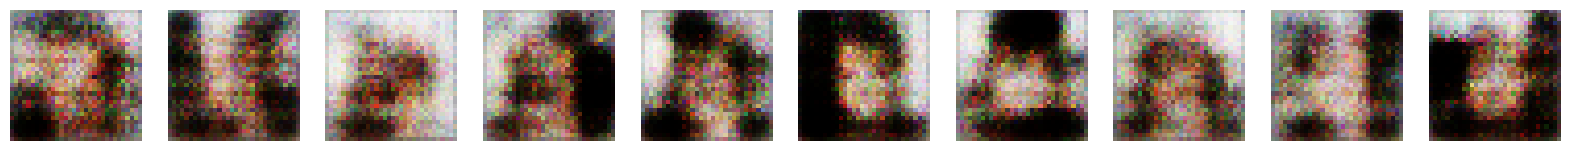

2/2 [==============================] - 3s 23ms/step
FID score at epoch 0: 487.20160687234727
100/100 [==============================] - 789s 8s/step - c_loss: -19.4382 - c_wass_loss: -25.3706 - c_gp: 0.5932 - g_loss: 3.0699 - c_acc: 95.4208 - g_acc: 65.5322
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -6.2707 - c_wass_loss: -7.0045 - c_gp: 0.0734 - g_loss: 1.8950 - c_acc: 79.0469 - g_acc: 60.8438
Saved to ./output/generatedimg001.png


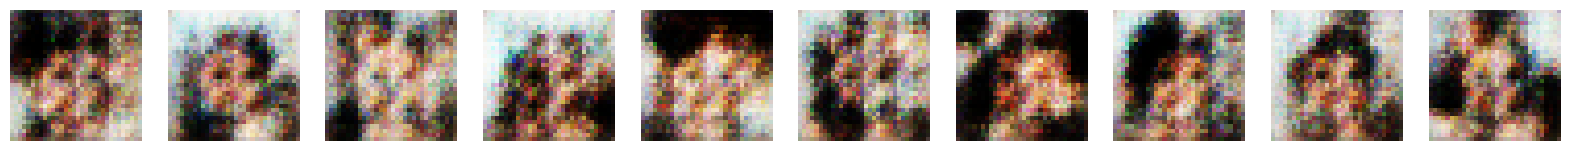

2/2 [==============================] - 0s 109ms/step
FID score at epoch 1: 513.1654195025458
100/100 [==============================] - 765s 8s/step - c_loss: -6.2707 - c_wass_loss: -7.0045 - c_gp: 0.0734 - g_loss: 1.8950 - c_acc: 79.2543 - g_acc: 60.4889
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -5.2230 - c_wass_loss: -5.7536 - c_gp: 0.0531 - g_loss: -1.7454 - c_acc: 83.7656 - g_acc: 41.0781
Saved to ./output/generatedimg002.png


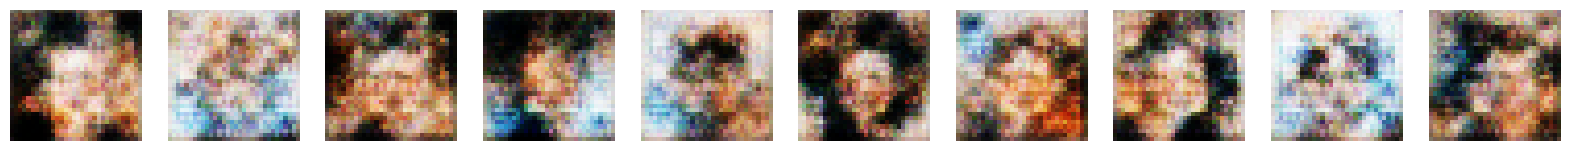

2/2 [==============================] - 0s 129ms/step
FID score at epoch 2: 469.57662364594967
100/100 [==============================] - 766s 8s/step - c_loss: -5.2230 - c_wass_loss: -5.7536 - c_gp: 0.0531 - g_loss: -1.7454 - c_acc: 83.7871 - g_acc: 41.2283
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -4.4593 - c_wass_loss: -4.8718 - c_gp: 0.0413 - g_loss: -6.4380 - c_acc: 90.8438 - g_acc: 20.7031
Saved to ./output/generatedimg003.png


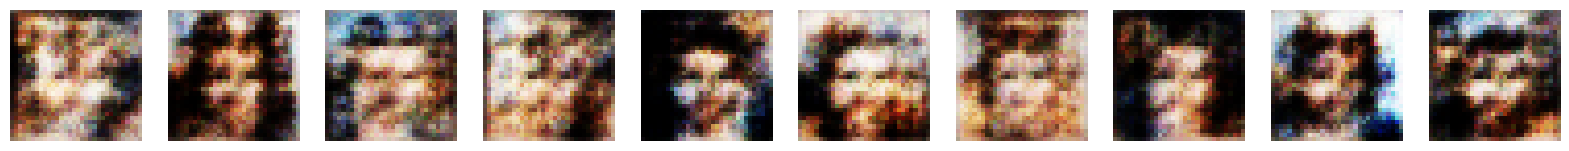

2/2 [==============================] - 0s 107ms/step
FID score at epoch 3: 514.2174131315168
100/100 [==============================] - 763s 8s/step - c_loss: -4.4593 - c_wass_loss: -4.8718 - c_gp: 0.0413 - g_loss: -6.4380 - c_acc: 90.7952 - g_acc: 20.7611
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -3.8202 - c_wass_loss: -4.1319 - c_gp: 0.0312 - g_loss: -12.0295 - c_acc: 94.8750 - g_acc: 10.0000
Saved to ./output/generatedimg004.png


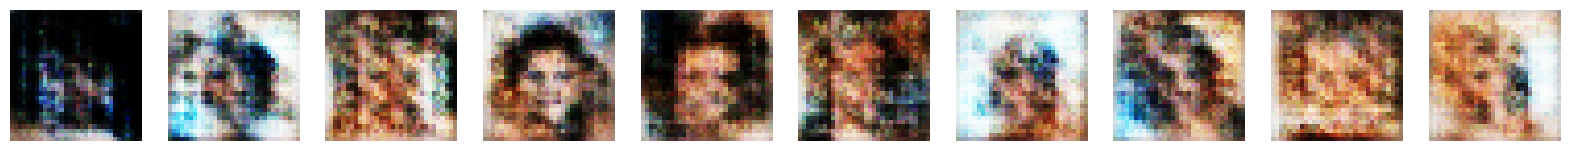

2/2 [==============================] - 0s 154ms/step
FID score at epoch 4: 508.45869245605616
100/100 [==============================] - 750s 8s/step - c_loss: -3.8202 - c_wass_loss: -4.1319 - c_gp: 0.0312 - g_loss: -12.0295 - c_acc: 94.8175 - g_acc: 10.0093


In [ ]:
loss_history = LossHistory()

wgangp.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

In [ ]:
# Save the final models
generator.save("./models/generator_GA")
critic.save("./models/critic_GA")

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -3.5031 - c_wass_loss: -3.7503 - c_gp: 0.0247 - g_loss: -17.8536 - c_acc: 99.6250 - g_acc: 1.1406
Saved to ./output/generatedimg000.png


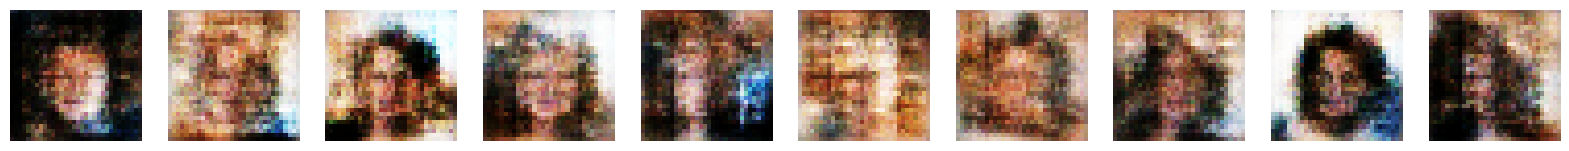

2/2 [==============================] - 0s 99ms/step
FID score at epoch 0: 537.2906917751599
100/100 [==============================] - 28s 272ms/step - c_loss: -3.5031 - c_wass_loss: -3.7503 - c_gp: 0.0247 - g_loss: -17.8536 - c_acc: 99.6287 - g_acc: 1.1293
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -3.4276 - c_wass_loss: -3.6655 - c_gp: 0.0238 - g_loss: -23.9110 - c_acc: 99.9844 - g_acc: 0.0781
Saved to ./output/generatedimg001.png


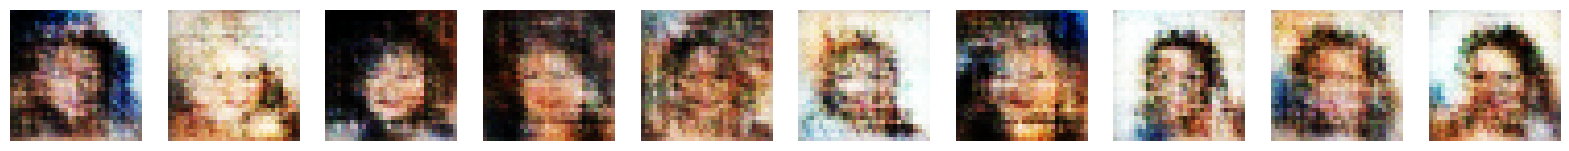

2/2 [==============================] - 0s 98ms/step
FID score at epoch 1: 533.8230666270936
100/100 [==============================] - 27s 273ms/step - c_loss: -3.4276 - c_wass_loss: -3.6655 - c_gp: 0.0238 - g_loss: -23.9110 - c_acc: 99.9845 - g_acc: 0.0774
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -3.2208 - c_wass_loss: -3.4458 - c_gp: 0.0225 - g_loss: -25.5612 - c_acc: 100.0000 - g_acc: 0.0625
Saved to ./output/generatedimg002.png


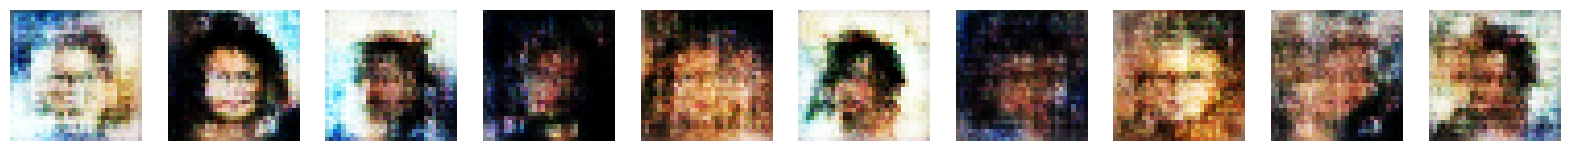

2/2 [==============================] - 0s 100ms/step
FID score at epoch 2: 562.3353120175365
100/100 [==============================] - 28s 284ms/step - c_loss: -3.2208 - c_wass_loss: -3.4458 - c_gp: 0.0225 - g_loss: -25.5612 - c_acc: 100.0000 - g_acc: 0.0619
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.9872 - c_wass_loss: -3.1943 - c_gp: 0.0207 - g_loss: -27.5351 - c_acc: 100.0000 - g_acc: 0.0156
Saved to ./output/generatedimg003.png


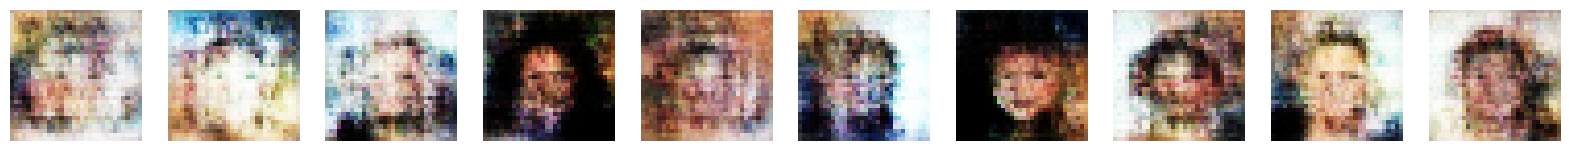

2/2 [==============================] - 0s 115ms/step
FID score at epoch 3: 548.3891000540884
100/100 [==============================] - 27s 275ms/step - c_loss: -2.9872 - c_wass_loss: -3.1943 - c_gp: 0.0207 - g_loss: -27.5351 - c_acc: 100.0000 - g_acc: 0.0155
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -3.0511 - c_wass_loss: -3.2691 - c_gp: 0.0218 - g_loss: -28.3102 - c_acc: 99.9844 - g_acc: 0.0469
Saved to ./output/generatedimg004.png


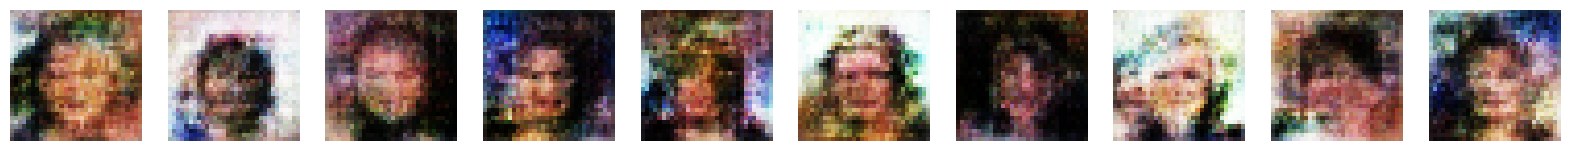

2/2 [==============================] - 0s 101ms/step
FID score at epoch 4: 548.6583331834975
100/100 [==============================] - 28s 277ms/step - c_loss: -3.0511 - c_wass_loss: -3.2691 - c_gp: 0.0218 - g_loss: -28.3102 - c_acc: 99.9845 - g_acc: 0.0464


In [ ]:
wgangp.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.9389 - c_wass_loss: -3.1358 - c_gp: 0.0197 - g_loss: -29.8005 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generatedimg000.png


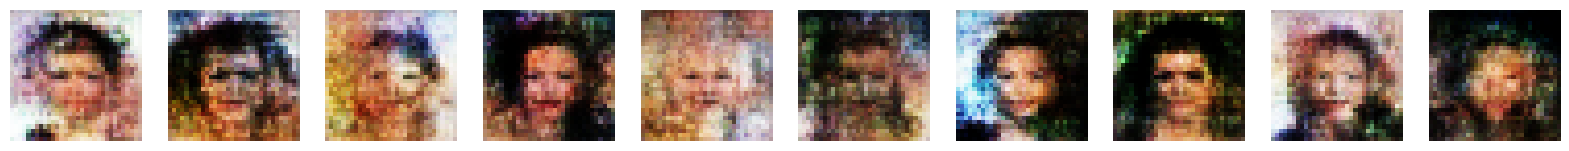

2/2 [==============================] - 0s 104ms/step
FID score at epoch 0: 641.9365374371703
100/100 [==============================] - 28s 271ms/step - c_loss: -2.9389 - c_wass_loss: -3.1358 - c_gp: 0.0197 - g_loss: -29.8005 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.8265 - c_wass_loss: -3.0061 - c_gp: 0.0180 - g_loss: -31.8346 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generatedimg001.png


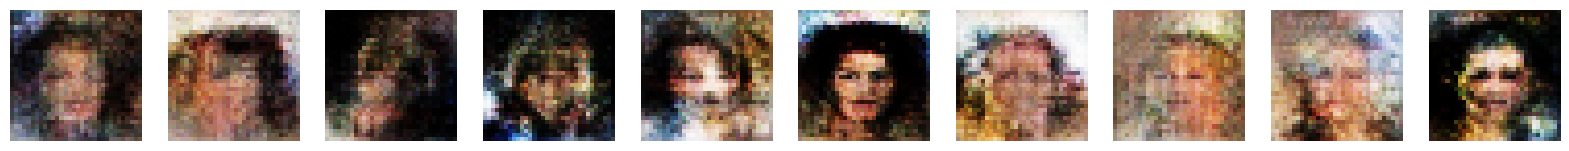

2/2 [==============================] - 0s 105ms/step
FID score at epoch 1: 531.2571258407362
100/100 [==============================] - 28s 282ms/step - c_loss: -2.8265 - c_wass_loss: -3.0061 - c_gp: 0.0180 - g_loss: -31.8346 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7796 - c_wass_loss: -2.9883 - c_gp: 0.0209 - g_loss: -30.8431 - c_acc: 99.9844 - g_acc: 0.0000e+00
Saved to ./output/generatedimg002.png


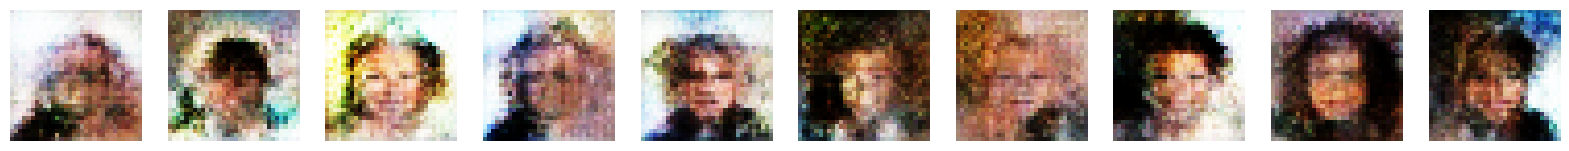

2/2 [==============================] - 0s 101ms/step
FID score at epoch 2: 631.2159802812209
100/100 [==============================] - 28s 276ms/step - c_loss: -2.7796 - c_wass_loss: -2.9883 - c_gp: 0.0209 - g_loss: -30.8431 - c_acc: 99.9845 - g_acc: 0.0000e+00
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.6859 - c_wass_loss: -2.8790 - c_gp: 0.0193 - g_loss: -30.0717 - c_acc: 99.9375 - g_acc: 0.2969
Saved to ./output/generatedimg003.png


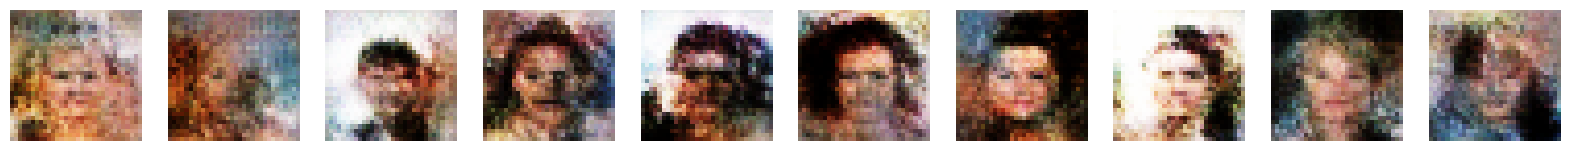

2/2 [==============================] - 0s 112ms/step
FID score at epoch 3: 593.5554272647039
100/100 [==============================] - 28s 283ms/step - c_loss: -2.6859 - c_wass_loss: -2.8790 - c_gp: 0.0193 - g_loss: -30.0717 - c_acc: 99.9381 - g_acc: 0.2939
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7017 - c_wass_loss: -2.8863 - c_gp: 0.0185 - g_loss: -30.5033 - c_acc: 100.0000 - g_acc: 0.0312
Saved to ./output/generatedimg004.png


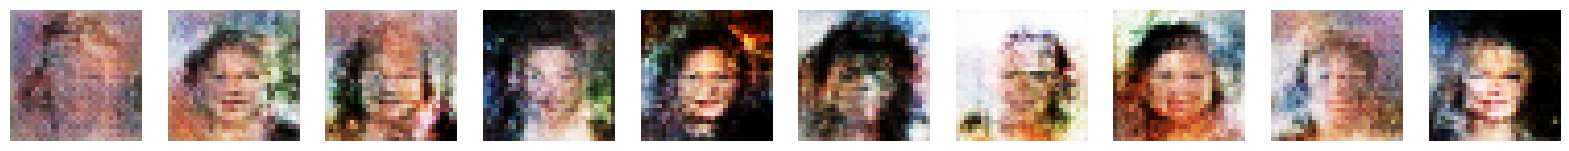

2/2 [==============================] - 0s 122ms/step
FID score at epoch 4: 585.038885614092
100/100 [==============================] - 28s 286ms/step - c_loss: -2.7017 - c_wass_loss: -2.8863 - c_gp: 0.0185 - g_loss: -30.5033 - c_acc: 100.0000 - g_acc: 0.0309


In [ ]:
wgangp.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - c_loss: -2.5921 - c_wass_loss: -2.7742 - c_gp: 0.0182 - g_loss: -27.0394 - c_acc: 99.9531 - g_acc: 0.1094
Saved to ./output/generatedimg000.png


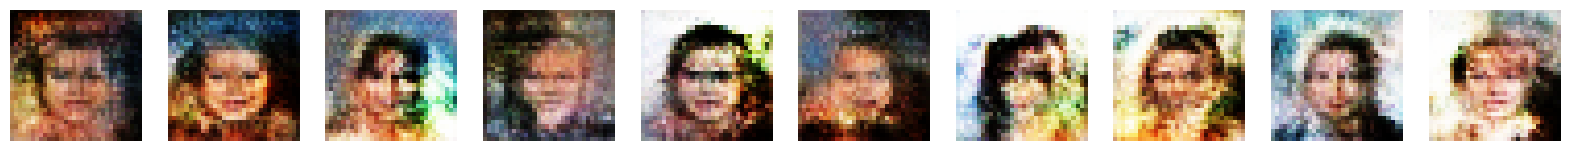

2/2 [==============================] - 0s 101ms/step
FID score at epoch 0: 673.4725627498276
100/100 [==============================] - 28s 272ms/step - c_loss: -2.5921 - c_wass_loss: -2.7742 - c_gp: 0.0182 - g_loss: -27.0394 - c_acc: 99.9536 - g_acc: 0.1083
Epoch 2/5
100/100 [==============================] - ETA: 0s - c_loss: -2.7447 - c_wass_loss: -2.9074 - c_gp: 0.0163 - g_loss: -27.6856 - c_acc: 100.0000 - g_acc: 0.0625
Saved to ./output/generatedimg001.png


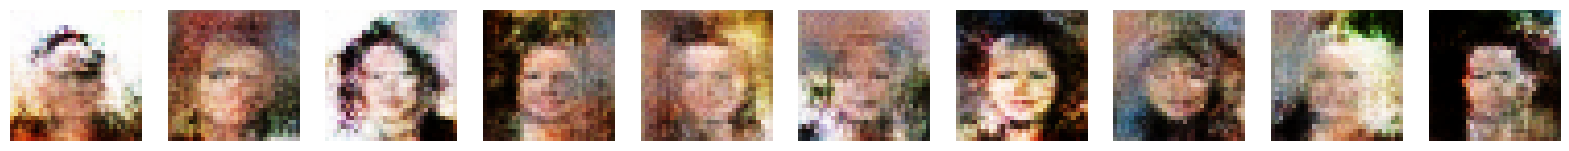

2/2 [==============================] - 0s 98ms/step
FID score at epoch 1: 561.4059578857698
100/100 [==============================] - 27s 273ms/step - c_loss: -2.7447 - c_wass_loss: -2.9074 - c_gp: 0.0163 - g_loss: -27.6856 - c_acc: 100.0000 - g_acc: 0.0619
Epoch 3/5
100/100 [==============================] - ETA: 0s - c_loss: -2.9472 - c_wass_loss: -3.1793 - c_gp: 0.0232 - g_loss: -24.7175 - c_acc: 99.5625 - g_acc: 1.1250
Saved to ./output/generatedimg002.png


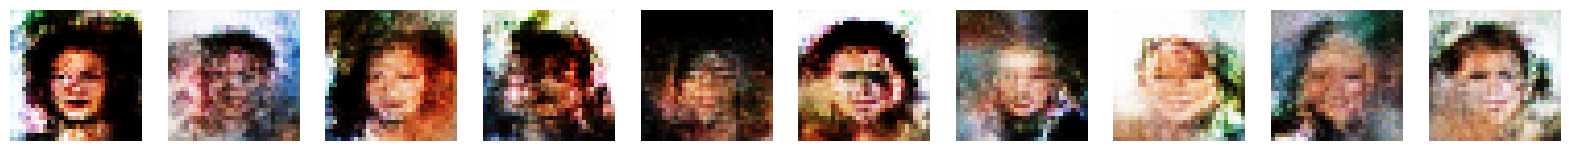

2/2 [==============================] - 0s 101ms/step
FID score at epoch 2: 561.1208722788897
100/100 [==============================] - 28s 277ms/step - c_loss: -2.9472 - c_wass_loss: -3.1793 - c_gp: 0.0232 - g_loss: -24.7175 - c_acc: 99.5668 - g_acc: 1.1139
Epoch 4/5
100/100 [==============================] - ETA: 0s - c_loss: -2.9657 - c_wass_loss: -3.1922 - c_gp: 0.0227 - g_loss: -24.2171 - c_acc: 99.1406 - g_acc: 1.1875
Saved to ./output/generatedimg003.png


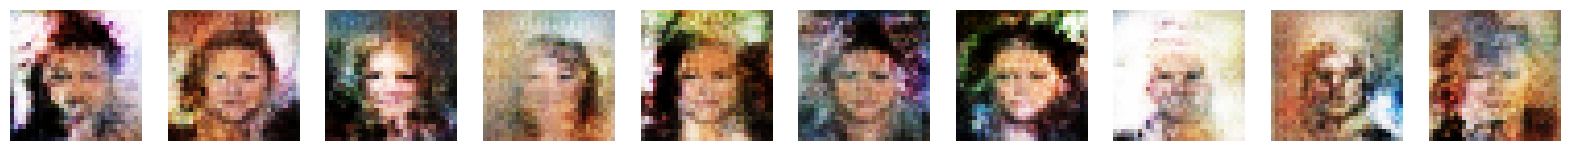

2/2 [==============================] - 0s 100ms/step
FID score at epoch 3: 665.5531951534435
100/100 [==============================] - 28s 279ms/step - c_loss: -2.9657 - c_wass_loss: -3.1922 - c_gp: 0.0227 - g_loss: -24.2171 - c_acc: 99.1491 - g_acc: 1.1757
Epoch 5/5
100/100 [==============================] - ETA: 0s - c_loss: -2.6747 - c_wass_loss: -2.8999 - c_gp: 0.0225 - g_loss: -25.8234 - c_acc: 99.1406 - g_acc: 1.2188
Saved to ./output/generatedimg004.png


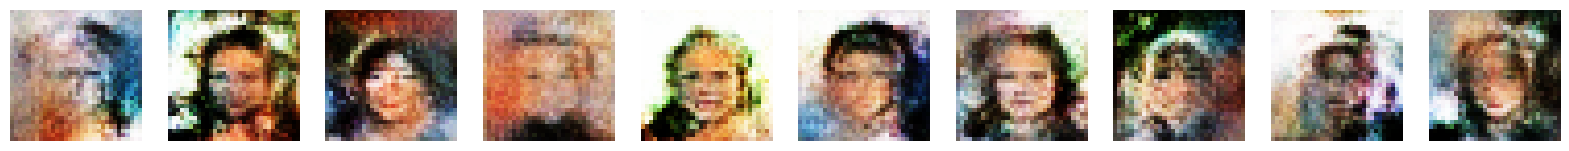

2/2 [==============================] - 0s 102ms/step
FID score at epoch 4: 622.7093790367444
100/100 [==============================] - 28s 278ms/step - c_loss: -2.6747 - c_wass_loss: -2.8999 - c_gp: 0.0225 - g_loss: -25.8234 - c_acc: 99.1491 - g_acc: 1.2067


In [ ]:
wgangp.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM, real_images=real_images, fid_model=fid_model), loss_history],
)

In [ ]:
# Save the final models
generator.save("./models/generator_GA2")
critic.save("./models/critic_GA2")

# Show images

1/1 [==============================] - 0s 243ms/step


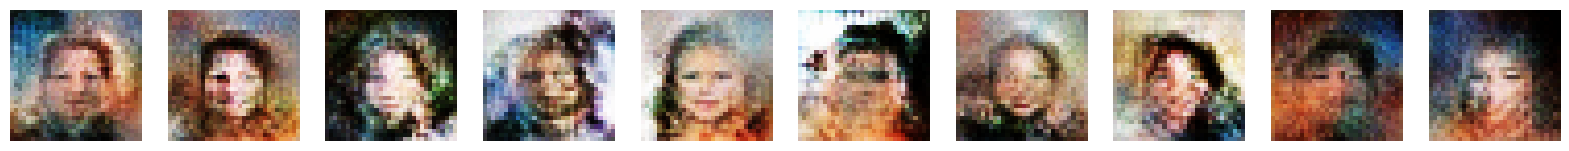

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

1/1 [==============================] - 0s 20ms/step


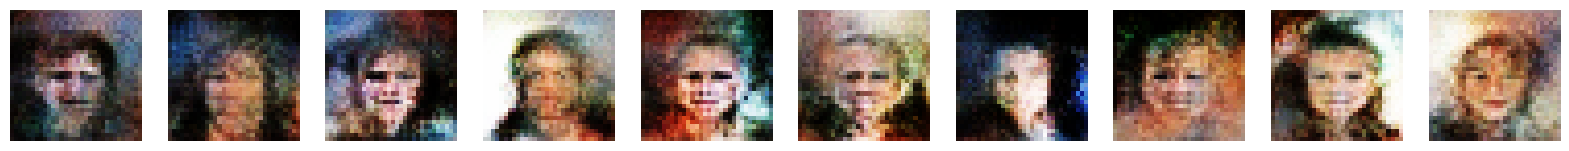

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

1/1 [==============================] - 0s 27ms/step


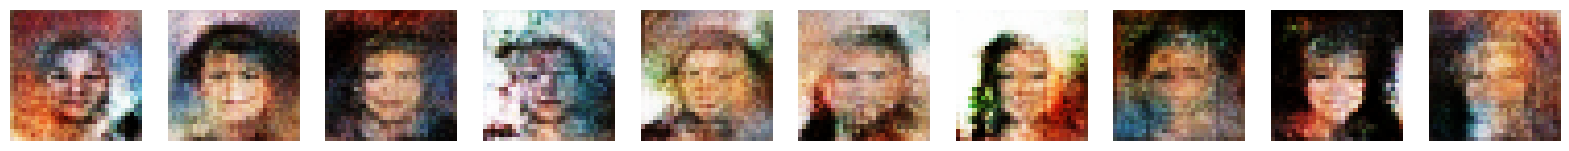

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

# Interpolate

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

1/1 [==============================] - 0s 33ms/step


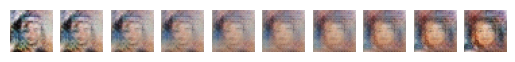

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	for i in range(n):
		pyplot.subplot(1, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :])
	pyplot.show()


pts = generate_latent_points(Z_DIM, 2)
interpolated = interpolate_points(pts[0], pts[1])
X = wgangp.generator.predict(interpolated)
X = (X + 1) / 2.0

plot_generated(X, len(interpolated))

1/1 [==============================] - 0s 19ms/step


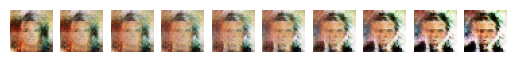

In [ ]:
# generate points in latent space
pts = generate_latent_points(Z_DIM, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = wgangp.generator.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

1/1 [==============================] - 0s 35ms/step


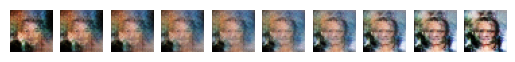

In [ ]:
# generate points in latent space
pts = generate_latent_points(Z_DIM, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = wgangp.generator.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))